In [1]:
# Render our plots inline
%matplotlib inline
%pylab inline  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# General Plotting Parameters
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 14.
mpl.rcParams['legend.fontsize'] = 12.
mpl.rcParams['axes.labelsize'] = 12.
mpl.rcParams['xtick.labelsize'] = 10.
mpl.rcParams['ytick.labelsize'] = 10.
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

#Git says this is patched, but it doesn't work from Pip --upgrade 26-mar-2015
#mpl.rcParams['xtick.minor.visible'] = True  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
             (255, 187, 120), (44, 160, 44), (152, 223, 138),
              (148, 103, 189),
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127),
             (199, 199, 199), (188, 189, 34), (219, 219, 141),
             (23, 190, 207), (158, 218, 229),(214, 39, 40), (255, 152, 150)]  
    
# Scale the RGB values to the [0, 1] range,
# which is the format matplotlib accepts.  
for i in range(len(tableau20)): 
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
plot_dir = './' 

ps = 1

Populating the interactive namespace from numpy and matplotlib


In [2]:
import calc_enrich
reload(calc_enrich)
from calc_enrich import calc_del_U
from calc_enrich import Npc_from_Nstages
from calc_enrich import Nwc_from_Nstages
from calc_enrich import calc_feed_flows
from calc_enrich import find_N_stages
from calc_enrich import design_cascade

In [3]:
# centrifuge params 
#omega = 64000
#d = 0.1  # m 
#Z = 2.0   # m
#F_m_hrs = 70 # grams/hr  
#T = 320.0   # K
#cut = 0.5
eff = 1.0 # centrifuge efficiency

d = 0.15  # m 
Z = 1.0   # m
F_m_hrs = 15*60*60/(1e3) # grams/hr  
T = 320.0# K
cut = 0.5
omega = 485/(d/2)

# cascade params
Nfc = 0.007
Npc = 0.035
Nwc = 0.003
Fc_month = 739 #kg/month

# The feed enrichment to be used when using a cascade designed for LEU to produce HEU.
Nfc_mod = 0.20
Fc_month_mod = Fc_month #kg/month
#Fc_month_mod = 46 #kg/month

#unit conversions
kg_sec2kg_month = 30.4*24*60*60
v_a = omega * (d/2.0)
F_m = F_m_hrs/(60*60*1000.0)
Fc = Fc_month/kg_sec2kg_month
Fc_mod = Fc_month_mod/kg_sec2kg_month

# Comparison numbers (not needed for calculations)
del_U_th_yr = 1.1 #swu/yr
del_U_obs_yr = 0.71 #Swu/yr
del_U_th = del_U_th_yr/(365.25*24*60*60) #kgSWU/sec
del_U_obs = del_U_obs_yr/(365.25*24*60*60)

Pc_month = 77 #kg/month
Pc = Pc_month/kg_sec2kg_month

qty_len = 8
assay_len = 4

In [4]:
alpha, del_U, del_U_yr, dirac = calc_del_U(v_a, Z, d, F_m, T, cut, eff)

# Find the number of stages needed for enriching and stripping 
# (don't use the stages_per_cascade fn because it only works when alpha is close to 1)

ideal_enrich_stage, ideal_strip_stage = find_N_stages(alpha, Nfc, Npc, Nwc)
feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, Fc, cut)
all_stages, n_machines = design_cascade(cut, alpha, del_U, Nfc, feed_flows, ideal_enrich_stage, ideal_strip_stage,
                                        verbose=True, pretty=True, qty_len=qty_len)
print "total machines", n_machines


Stage   #Mach	 Feed    Product  Waste	 F_assay 	P_assay W_assay
0 	214 	2956.0    1478.0    1478.0    0.007 	0.0094 	0.0052
1 	178 	2463.33    1231.67    1231.67    0.0094 	0.0126 	0.007
2 	143 	1970.67    985.33    985.33    0.0126 	0.017 	0.0094
3 	107 	1478.0    739.0    739.0    0.017 	0.0227 	0.0126
4 	72 	985.33    492.67    492.67    0.0227 	0.0304 	0.017
5 	36 	492.67    246.33    246.33    0.0304 	0.0405 	0.0227
-1 	143 	1970.67    985.33    985.33    0.0052 	0.007 	0.0039
-2 	72 	985.33    492.67    492.67    0.0039 	0.0052 	0.0029
total machines 965


In [5]:
tot_flow = 0
p_last = 0
w_next = 0
for i in range(len(all_stages)):
    if (i == 0):
        p_last = 0
    else:
        p_last = all_stages[i-1][3]
    if (i == len(all_stages)-1):
        w_next = 0
    else:
        w_next = all_stages[i+1][4]
    # If on stage zero then add feed also
    if (i == (ideal_strip_stage)):
        tot_flow = p_last+w_next+Fc
    else:
        tot_flow =  p_last+w_next
    print "stage", i - ideal_strip_stage,"Predicted flow ", feed_flows[i]," actual flow ", tot_flow


stage -2 Predicted flow  0.000375142137752  actual flow  0.000375142137752
stage -1 Predicted flow  0.000750284275504  actual flow  0.000750284275504
stage 0 Predicted flow  0.00112542641326  actual flow  0.00112542641326
stage 1 Predicted flow  0.000937855344379  actual flow  0.000937855344379
stage 2 Predicted flow  0.000750284275504  actual flow  0.000750284275504
stage 3 Predicted flow  0.000562713206628  actual flow  0.000562713206628
stage 4 Predicted flow  0.000375142137752  actual flow  0.000375142137752
stage 5 Predicted flow  0.000187571068876  actual flow  0.000187571068876


In [6]:
## Check that mass is conserved in the cascade

final_w = all_stages[0][4]
final_p = all_stages[len(all_stages)-1][3]
#final_f = round(Fc,qty_len)
final_f = Fc

res = final_f - final_p - final_w
print "Casc. F (kg/s)  Casc. P\t\tCasc. W\t\t (P+W)/F"
print  final_f, "\t", final_p, "\t", final_w, "\t", (final_p+final_w)/final_f

Casc. F (kg/s)  Casc. P		Casc. W		 (P+W)/F
0.000281356603314 	9.37855344379e-05 	0.000187571068876 	1.0


In [7]:
## Determine cascade production rate for off-design use

Npc_mod = Npc_from_Nstages(alpha, Nfc_mod, ideal_enrich_stage)
Nwc_mod = Nwc_from_Nstages(alpha, Nfc_mod, ideal_strip_stage)

feed_flow_mod = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, Fc_mod, cut)

mod_stages, n_m = design_cascade(cut, alpha, del_U, Nfc_mod, feed_flow_mod, ideal_enrich_stage,
                                 ideal_strip_stage, verbose=True, pretty=True, qty_len=qty_len)


Stage   #Mach	 Feed    Product  Waste	 F_assay 	P_assay W_assay
0 	214 	2956.0    1478.0    1478.0    0.2 	0.252 	0.1565
1 	178 	2463.33    1231.67    1231.67    0.252 	0.3123 	0.2
2 	143 	1970.67    985.33    985.33    0.3123 	0.3797 	0.252
3 	107 	1478.0    739.0    739.0    0.3797 	0.4521 	0.3123
4 	72 	985.33    492.67    492.67    0.4521 	0.5265 	0.3797
5 	36 	492.67    246.33    246.33    0.5265 	0.5998 	0.4521
-1 	143 	1970.67    985.33    985.33    0.1565 	0.2 	0.121
-2 	72 	985.33    492.67    492.67    0.121 	0.1565 	0.0926


In [8]:
## Design Cascade based on available number of centrifuges, determine max Fc
max_centrifuges = 100
curr_feed = Fc
optimal_feed = Fc
step_size = 1.2  # MUST be a number Greater than 1. 
step = 1
ideal_enrich_stage, ideal_strip_stage = find_N_stages(alpha, Nfc, Npc, Nwc)
feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, curr_feed, cut)
all_stages, n_centrifuges = design_cascade(cut, alpha, del_U, Nfc, feed_flows, ideal_enrich_stage, ideal_strip_stage)

optimum_number = False
neg_inc = False
pos_inc = False

if (n_centrifuges < max_centrifuges):
    pos_inc = True
    step = step_size
elif (n_centrifuges > max_centrifuges):
    neg_inc = True
    step = 1.0/step_size
else:
    optimum_number = True
ntries=0
print "step size is", step
while (optimum_number == False) and (ntries < 100):
    ntries+=1
    last_feed = curr_feed
    curr_feed *= step
    feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, curr_feed, cut)
    all_stages, n_centrifuges = design_cascade(cut, alpha, del_U, Nfc, feed_flows, ideal_enrich_stage, 
                                               ideal_strip_stage)
    print "curr try", ntries, "Tot mach", n_centrifuges, "# in last stage: ", all_stages[-1][1]
    if (all_stages[-1][1] < 1):
        print "not enough centrifuges to fill all stages"
        optimum_number = True
        optimal_feed = last_feed
    elif (neg_inc == True) and (n_centrifuges < max_centrifuges):
        optimum_number = True
        optimal_feed = curr_feed
        print "reduced flow to correct #", n_centrifuges
    elif (pos_inc == True) and (n_centrifuges > max_centrifuges):
        optimum_number = True
        optimal_feed = last_feed
        print "increased flow to correct #", n_centrifuges

final_feed_flows = calc_feed_flows(ideal_enrich_stage, ideal_strip_stage, optimal_feed, cut)
final_stages, final_n_mach = design_cascade(cut, alpha, del_U, Nfc, final_feed_flows, 
                                            ideal_enrich_stage, ideal_strip_stage, verbose=True, pretty=True)
print "Cascade can process ", optimal_feed*kg_sec2kg_month, " kg/month"
print "Final total machines", final_n_mach
print final_stages[:][0]

step size is 0.833333333333
curr try 1 Tot mach 804 # in last stage:  30
curr try 2 Tot mach 671 # in last stage:  25
curr try 3 Tot mach 560 # in last stage:  21
curr try 4 Tot mach 467 # in last stage:  18
curr try 5 Tot mach 390 # in last stage:  15
curr try 6 Tot mach 324 # in last stage:  12
curr try 7 Tot mach 270 # in last stage:  10
curr try 8 Tot mach 228 # in last stage:  9
curr try 9 Tot mach 189 # in last stage:  7
curr try 10 Tot mach 158 # in last stage:  6
curr try 11 Tot mach 133 # in last stage:  5
curr try 12 Tot mach 108 # in last stage:  4
curr try 13 Tot mach 93 # in last stage:  4
reduced flow to correct # 93
Stage   #Mach	 Feed    Product  Waste	 F_assay 	P_assay W_assay
0 	20 	276.28    138.14    138.14    0.007 	0.0094 	0.0052
1 	17 	230.23    115.12    115.12    0.0094 	0.0126 	0.007
2 	14 	184.19    92.09    92.09    0.0126 	0.017 	0.0094
3 	10 	138.14    69.07    69.07    0.017 	0.0227 	0.0126
4 	7 	92.09    46.05    46.05    0.0227 	0.0304 	0.017
5 	4 	46.0

In [9]:
## A cascade with a fixed number of centrifuges has a maximum flow rate already defined
## This flow rate and production does not change with change to feed assay. Therefore the
## only things that change with a modified cascade are the product and waste assays

/Users/mbmcgarry/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


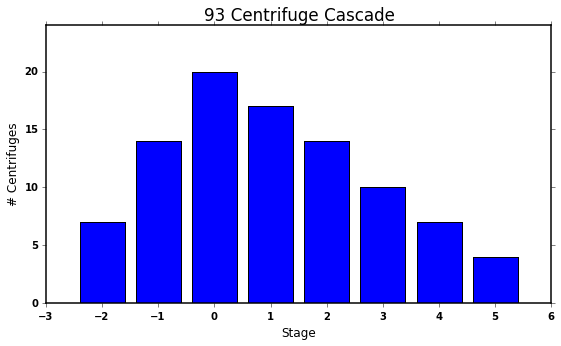

In [10]:
all_stages = []

for s in range(len(final_stages)):
    all_stages.append([final_stages[s][0],final_stages[s][1]])

fs = np.array(all_stages)
bar_width = 0.8
bar_res = plt.bar(fs[:,0]-0.4, fs[:,1], bar_width)

plt.xlabel('Stage')
plt.ylabel('# Centrifuges')
plt.title(str(int(final_n_mach)) + " Centrifuge Cascade")
plt.legend()
plt.ylim((0,1.2*fs[:,1].max()))
plt.tight_layout()

if ps == 1:
    savefig(plot_dir + 'cascade_design.png')

plt.show()
